<a href="https://colab.research.google.com/github/sdgroeve/D012513A-Specialised-Bio-informatics-Machine-Learning/blob/main/practicum_I/Splice_Site_Prediction%2Bsolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings;
warnings.filterwarnings('ignore');
import pandas as pd

# Splice site prediction

Gene splicing is a post-transcriptional modification in which a single gene can code for multiple proteins. Gene Splicing is done in eukaryotes, prior to mRNA translation, by the differential inclusion or exclusion of regions of pre-mRNA. Gene splicing is an important source of protein diversity.

The vast majority of splice sites are characterized by the presence of specific dimers on the intronic side of the splice site: "GT" for donor and "AG" for acceptor sites. In this project you will fit a classification model for acceptor splice site prediction in DNA sequences.

This model will consider each AG in the DNA as a candidate acceptor site, extract a local context surrounding the candidate acceptor site, represent the candidate site as a feature vector and the predict the class ('acceptor site' or 'not acceptor site') by applying the model in the constructed feature vector.

The folder that contains the annotated acceptor site data is on GitHub at the following location:

In [ ]:
data_location = "https://raw.githubusercontent.com/sdgroeve/D012513A-Specialised-Bio-informatics-Machine-Learning/main/practicum_I/"

The dataset we will use for fitting (training) our predictive model can be found in this comma-separated `.csv` file:

In [ ]:
data_name = "acceptor_site_dataset.csv"

Read this `.csv` file from the `data_location` folder into a Pandas DataFrame called `data`: 

In [ ]:
###Start code here

data = pd.read_csv(data_location + data_name)

###End code here

Print the first 5 rows in `data`:

In [ ]:
###Start code here

print(data.head(5))

###End code here

                 sequence  label subset
0  TTTGAATTGTAGGTGTCCTGCT      1  train
1  TATTTTTTAAAGAACTGGAAGA      1  train
2  TTTCTTTTTCAGATGAAGAATG      1  train
3  TATTAATTTCAGTTTGGTTGTT      1  train
4  TAAAAATTTAAGTTCGTCCCGA      1  train


We can see that there are three columns in the dataset. 

The column `sequence` contains the local context DNA sequence. The nucleotide positions 11 and 12 in the sequence are the candidate acceptor site and have value "A" and "G" for all rows in the dataset. The local context consists of 10 nucleotides upstream en 10 nucleotides downstream the candidate acceptor site. 

The column `label` contains the class of the candidate acceptor site: 1 for "is acceptor site" and 0 for "is not acceptor site". 

The column `subset` indicates if the row (instance) is part of the trainset or the testset.

Use the Pandas DataFrame `value_counts()` summary function to print the number of instances in the trainset and the testset:


In [ ]:
###Start code here

print(data.subset.value_counts())

###End code here

train    2752
test      552
Name: subset, dtype: int64


To fit a logistic regression model on the trainset we need to represent the local context DNA sequence as a numerical feature vector suitable for model fitting. This process is known as **feature engineering**. 

The "AG" dinucleotide in the middle of each local context sequence is the same for both classes, i.e. it does not provide any discriminative information. So, there is no rational behind computing features from this part of the local context sequence.

Use the Pandas DataFrame `map()` method to remove the middle "AG" dinucleotides in the DNA sequences (don't create a new column):

In [ ]:
print(data.head())

###Start code here

data["sequence"] = data["sequence"].map(lambda x: x[0:10]+x[12:22])

###End code here

print(data.head())

                 sequence  label subset
0  TTTGAATTGTAGGTGTCCTGCT      1  train
1  TATTTTTTAAAGAACTGGAAGA      1  train
2  TTTCTTTTTCAGATGAAGAATG      1  train
3  TATTAATTTCAGTTTGGTTGTT      1  train
4  TAAAAATTTAAGTTCGTCCCGA      1  train
               sequence  label subset
0  TTTGAATTGTGTGTCCTGCT      1  train
1  TATTTTTTAAAACTGGAAGA      1  train
2  TTTCTTTTTCATGAAGAATG      1  train
3  TATTAATTTCTTTGGTTGTT      1  train
4  TAAAAATTTATTCGTCCCGA      1  train


Next, we create a feature for each of the nucleotide positions in the local context DNA sequence.

The [pandas.Series.str.split](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html) function splits a string in a column (pandas.Series) from the beginning, at the specified delimiter string.

I use this function to split the `sequence` column into one column for each nucleotide position. I also rename the resulting columns to better relfect their meaning: 

In [ ]:
data_features = data['sequence'].str.split('', expand=True).iloc[:,1:21]
data_features.columns = ["%i"%i for i in range(-10,0,1)] + ["%i"%i for i in range(1,11,1)]

print(data_features)

     -10 -9 -8 -7 -6 -5 -4 -3 -2 -1  1  2  3  4  5  6  7  8  9 10
0      T  T  T  G  A  A  T  T  G  T  G  T  G  T  C  C  T  G  C  T
1      T  A  T  T  T  T  T  T  A  A  A  A  C  T  G  G  A  A  G  A
2      T  T  T  C  T  T  T  T  T  C  A  T  G  A  A  G  A  A  T  G
3      T  A  T  T  A  A  T  T  T  C  T  T  T  G  G  T  T  G  T  T
4      T  A  A  A  A  A  T  T  T  A  T  T  C  G  T  C  C  C  G  A
...   .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. ..
3299   T  T  T  G  A  A  G  T  T  T  C  T  T  C  C  T  T  C  T  C
3300   C  T  G  C  T  A  A  T  A  T  T  G  A  C  A  G  C  A  A  T
3301   T  T  C  C  A  A  A  T  A  T  G  A  A  A  A  T  C  G  A  A
3302   A  A  A  A  T  G  T  C  G  C  A  A  C  A  A  C  A  A  G  A
3303   A  G  A  A  G  T  A  T  G  G  G  T  G  G  A  A  T  G  T  T

[3304 rows x 20 columns]


Next you will map each of the nucleotides to a numerical value. Create a Python function `map_nucleotide_to_number()` that maps nucleotides A, C, G and T to 0, 1, 2 and 3 respectively:

In [ ]:
###Start code here

def map_nucleotide_to_number(x):
    if x == 'A':
        return 0
    if x == 'C':
        return 1
    if x == 'G':
        return 2
    if x == 'T':
        return 3

###End code here

for nucleotide, mapped_number in zip(['A','C','G','T'],range(4)):
    if map_nucleotide_to_number(nucleotide) != mapped_number:
        print("Function is not working for nucleotide %s"%nucleotide)
    else:
        print("Function works for nucleotide %s"%nucleotide)

Function works for nucleotide A
Function works for nucleotide C
Function works for nucleotide G
Function works for nucleotide T


You have seen the Pandas DataFrame functions `map()` and `apply()`. Similar to these functions, there is also the function `applymap()` that applies a function to every element of a DataFrame.

Apply the `map_nucleotide_to_number()` you created to every element in the `data_features` DataFrame (write the resulting DataFrame to `data_features_numerical`):

In [ ]:
###Start code here

data_features_numerical = data_features.applymap(map_nucleotide_to_number)

###End code here

print(data_features_numerical)

      -10  -9  -8  -7  -6  -5  -4  -3  -2  -1  1  2  3  4  5  6  7  8  9  10
0       3   3   3   2   0   0   3   3   2   3  2  3  2  3  1  1  3  2  1   3
1       3   0   3   3   3   3   3   3   0   0  0  0  1  3  2  2  0  0  2   0
2       3   3   3   1   3   3   3   3   3   1  0  3  2  0  0  2  0  0  3   2
3       3   0   3   3   0   0   3   3   3   1  3  3  3  2  2  3  3  2  3   3
4       3   0   0   0   0   0   3   3   3   0  3  3  1  2  3  1  1  1  2   0
...   ...  ..  ..  ..  ..  ..  ..  ..  ..  .. .. .. .. .. .. .. .. .. ..  ..
3299    3   3   3   2   0   0   2   3   3   3  1  3  3  1  1  3  3  1  3   1
3300    1   3   2   1   3   0   0   3   0   3  3  2  0  1  0  2  1  0  0   3
3301    3   3   1   1   0   0   0   3   0   3  2  0  0  0  0  3  1  2  0   0
3302    0   0   0   0   3   2   3   1   2   1  0  0  1  0  0  1  0  0  2   0
3303    0   2   0   0   2   3   0   3   2   2  2  3  2  2  0  0  3  2  3   3

[3304 rows x 20 columns]


Finally, I contruct the trainset and testset feature vectors based on the `subset` column in `data`:

In [ ]:
X_train = data_features_numerical.loc[data.subset == "train"]
X_test = data_features_numerical.loc[data.subset == "test"]

Create Pandas Series `y_train` and `y_test` that contain the classes for the DataFrames `X_train` and `X_test` respectively:

In [ ]:
###Start code here

y_train = data.loc[data.subset == "train"]["label"]
y_test = data.loc[data.subset == "test"]["label"]

###End code here

How many instances of class '0' are there in the trainset? How many of class '1'?

In [ ]:
###Start code here

print(y_train.value_counts())

###End code here

0    2497
1     255
Name: label, dtype: int64


How many instances of class '0' are there in the testset? How many of class '1'?

In [ ]:
###Start code here

print(y_test.value_counts())

###End code here

0    497
1     55
Name: label, dtype: int64


Initialize the `LogisticRegression` model from `sklearn.linear_model`: 

In [ ]:
from sklearn.linear_model import LogisticRegression

###Start code here

lr_model = LogisticRegression()

###End code here

print(lr_model)

LogisticRegression()


Fit the logistic regression model `lr_ model` on the trainset `X_train`:

In [ ]:
###Start code here

lr_model.fit(X_train,y_train)

###End code here

LogisticRegression()

Compute class predictions for the testset `X_test`:

In [ ]:
###Start code here

predictions = lr_model.predict(X_test)

###End code here

print(predictions)

[1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 

Use the `accuracy_score()` function in `sklearn.metrics` to compute the accuracy of the predictions on the testset:

In [ ]:
from sklearn import metrics

###Start code here

score_acc = metrics.accuracy_score(y_test,predictions)

###Start code here

print(score_acc)


0.9202898550724637


An accuracy above 90% seems like a good score. But is it? Let's consider a model that predicts class '0' for all test points:

In [ ]:
predictions_zero = [0]*len(y_test)
print(predictions_zero)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

What is the accuracy of these predictions?

In [ ]:
###Start code here

score_acc = metrics.accuracy_score(y_test,predictions_zero)

###End code here

print(score_acc)

0.9003623188405797


So this should be a good score as well, even though the model did not learn anything.

For classification tasks where the classes are highly imbalanced, accuracy is not a good metric to evaluate the generalization performance. In fact, if there are 0.1% "AG" dinucleotides in a genome that are true acceptor sites then a model that predicts class '0' for each "AG" would have an accuracy of 99.9%.

You have seen how a ROC curve plots the true positive rate against the false positive rate. Both these metrics focus on the positive class, in our case the true acceptor sites. These metrics are much more suitable to evalute the performance of models on tasks with highly imbalanced classes. 

To transform a ROC curve into one metric we can use the area under the curve (AUC). This metric can be computed with the `roc_auc_score()` function in `sklearn.metrics`. 

What is the AUC score of the predictions computed on the testset?

In [ ]:
from sklearn.metrics import roc_auc_score

###Start code here

score_auc = roc_auc_score(y_test,predictions)

###End code here

print(score_auc)

0.6970184744832632


Now, let's print the predictions again:

In [ ]:
print(predictions)

[1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 

These are predicted classes.

To compute the AUC, we actually need these predictions to be scores (a continuous value).

For logistic regression these scores are the class probabilities predicted by the model (a value between 0 and 1). 

We can obtain these scores with the `predict_proba()` function of the `LogisticRegression` module as follows:

In [ ]:
predictions = pd.DataFrame(lr_model.predict_proba(X_test),columns=["prob_0","prob_1"])

print(predictions)

       prob_0    prob_1
0    0.327520  0.672480
1    0.425903  0.574097
2    0.341907  0.658093
3    0.999413  0.000587
4    0.942077  0.057923
..        ...       ...
547  0.823318  0.176682
548  0.996326  0.003674
549  0.997360  0.002640
550  0.984624  0.015376
551  0.970995  0.029005

[552 rows x 2 columns]


The first and second column contain the predicted probabilities for class '0' and '1' respectively. To compute the AUC we need to use the class probabilities of class '1'. 

Compute the AUC from the class probabilities of class '1' computed from the testset: 

In [ ]:
###Start code here

score_auc = metrics.roc_auc_score(y_test,predictions["prob_1"])

###End code here

print(score_auc)

0.897969635997805


Is this good generalization performance?

Transforming categorical features into ordered integers is maybe not a good idea as the nucleotides don't have any ordering (the columns are not ordinal features). 

It is better to transform a categorical feature into one binary feature for each category. This is known as [one-hot encoding](https://en.wikipedia.org/wiki/One-hot). 

We can create a one-hot encoded feature vector of categorical feature columns using the Pandas function `get_dummies()` as follows:

In [ ]:
data_features_onehot_encoding = pd.get_dummies(data_features)

print(data_features_onehot_encoding)

      -10_A  -10_C  -10_G  -10_T  -9_A  -9_C  -9_G  -9_T  -8_A  -8_C  ...  \
0         0      0      0      1     0     0     0     1     0     0  ...   
1         0      0      0      1     1     0     0     0     0     0  ...   
2         0      0      0      1     0     0     0     1     0     0  ...   
3         0      0      0      1     1     0     0     0     0     0  ...   
4         0      0      0      1     1     0     0     0     1     0  ...   
...     ...    ...    ...    ...   ...   ...   ...   ...   ...   ...  ...   
3299      0      0      0      1     0     0     0     1     0     0  ...   
3300      0      1      0      0     0     0     0     1     0     0  ...   
3301      0      0      0      1     0     0     0     1     0     1  ...   
3302      1      0      0      0     1     0     0     0     1     0  ...   
3303      1      0      0      0     0     0     1     0     1     0  ...   

      8_G  8_T  9_A  9_C  9_G  9_T  10_A  10_C  10_G  10_T  
0       1    0

What it the AUC on the testset for a model fitted on these one-hot encoded feature vectors in the trainset? 

In [ ]:
###Start code here

X_train = data_features_onehot_encoding.loc[data.subset == "train"]
X_test = data_features_onehot_encoding.loc[data.subset == "test"]

lr_model.fit(X_train,y_train)

predictions = pd.DataFrame(lr_model.predict_proba(X_test),columns=["prob_0","prob_1"])
score_auc = metrics.roc_auc_score(y_test,predictions["prob_1"])

###End code here

print(score_auc)

0.9851472471190781


Do you observe better AUC for the one-hot encoded feature vectors?

In scikit-learn a fitted logistic regression model has the fitted modelparameter values stored in `.coef_[0]`:

In [ ]:
print(lr_model.coef_[0])

[ 0.18535922 -0.17254465 -0.64432076  0.63155105  0.36323346  0.09664242
 -0.82511475  0.36528374  0.42644274 -0.00627464 -1.01475009  0.59462685
  0.2943751  -0.68264436 -0.36023434  0.74854847  0.62222768 -1.22208009
 -0.13600194  0.73589922  0.10617957  0.17511685 -0.97650548  0.69525393
 -0.30416484 -0.40788395 -1.10386006  1.81595372 -0.21790803 -1.20477227
 -1.11330282  2.53602798  0.0671242  -0.15447455 -1.36278366  1.45017887
 -0.6199823   2.10008164 -1.93416747  0.454113    0.31268108 -0.83265987
  1.45490251 -0.93487886 -0.35797043  0.26184045 -0.08013915  0.17631399
 -0.0247569   0.23742285  0.40959851 -0.6222196  -0.31194619  0.29535498
  0.42828426 -0.41164818 -0.20320261  0.19427966  0.3345353  -0.32556748
 -0.30042054  0.66079598  0.26838713 -0.62871771 -0.20485503  0.36583118
  0.2601907  -0.42112198 -0.24838684  0.44239752  0.33979426 -0.53376007
 -0.21496153  0.00264659  0.35339661 -0.1410368  -0.69564289  0.42731881
  0.38151408 -0.11314514]


For logistic regression this is one modelparameter for each feature (plus the interecept, which is not in `.coef_[0]`). 

Recall that for logistic regression a prediction is made by multiplying each fitted modelparameter with the corresponding feature, summing them and then squeezing this sum between 0 and 1 with the logistic function. 

Since all features have values 0 or 1, the modelparameter values indicate the contribution (importance) of a feature during prediction.

The following code creates a Pandas DataFrame `model_parameters` with two columns: `feature` that is the name of the feature that the modelparameter is associated with, and `parameter_value` that is the value of the fitted modelparameter:

In [ ]:
model_parameters = pd.DataFrame()
model_parameters["feature"] = data_features_onehot_encoding.columns
model_parameters["parameter_value"] = lr_model.coef_[0]
print(model_parameters)

   feature  parameter_value
0    -10_A         0.185359
1    -10_C        -0.172545
2    -10_G        -0.644321
3    -10_T         0.631551
4     -9_A         0.363233
..     ...              ...
75     9_T        -0.141037
76    10_A        -0.695643
77    10_C         0.427319
78    10_G         0.381514
79    10_T        -0.113145

[80 rows x 2 columns]


A Pandas DataFrame also has functions to [plot the data](https://pandas.pydata.org/docs/user_guide/visualization.html). Here I plot the modelparameter values as a bar chart:

<AxesSubplot:xlabel='feature'>

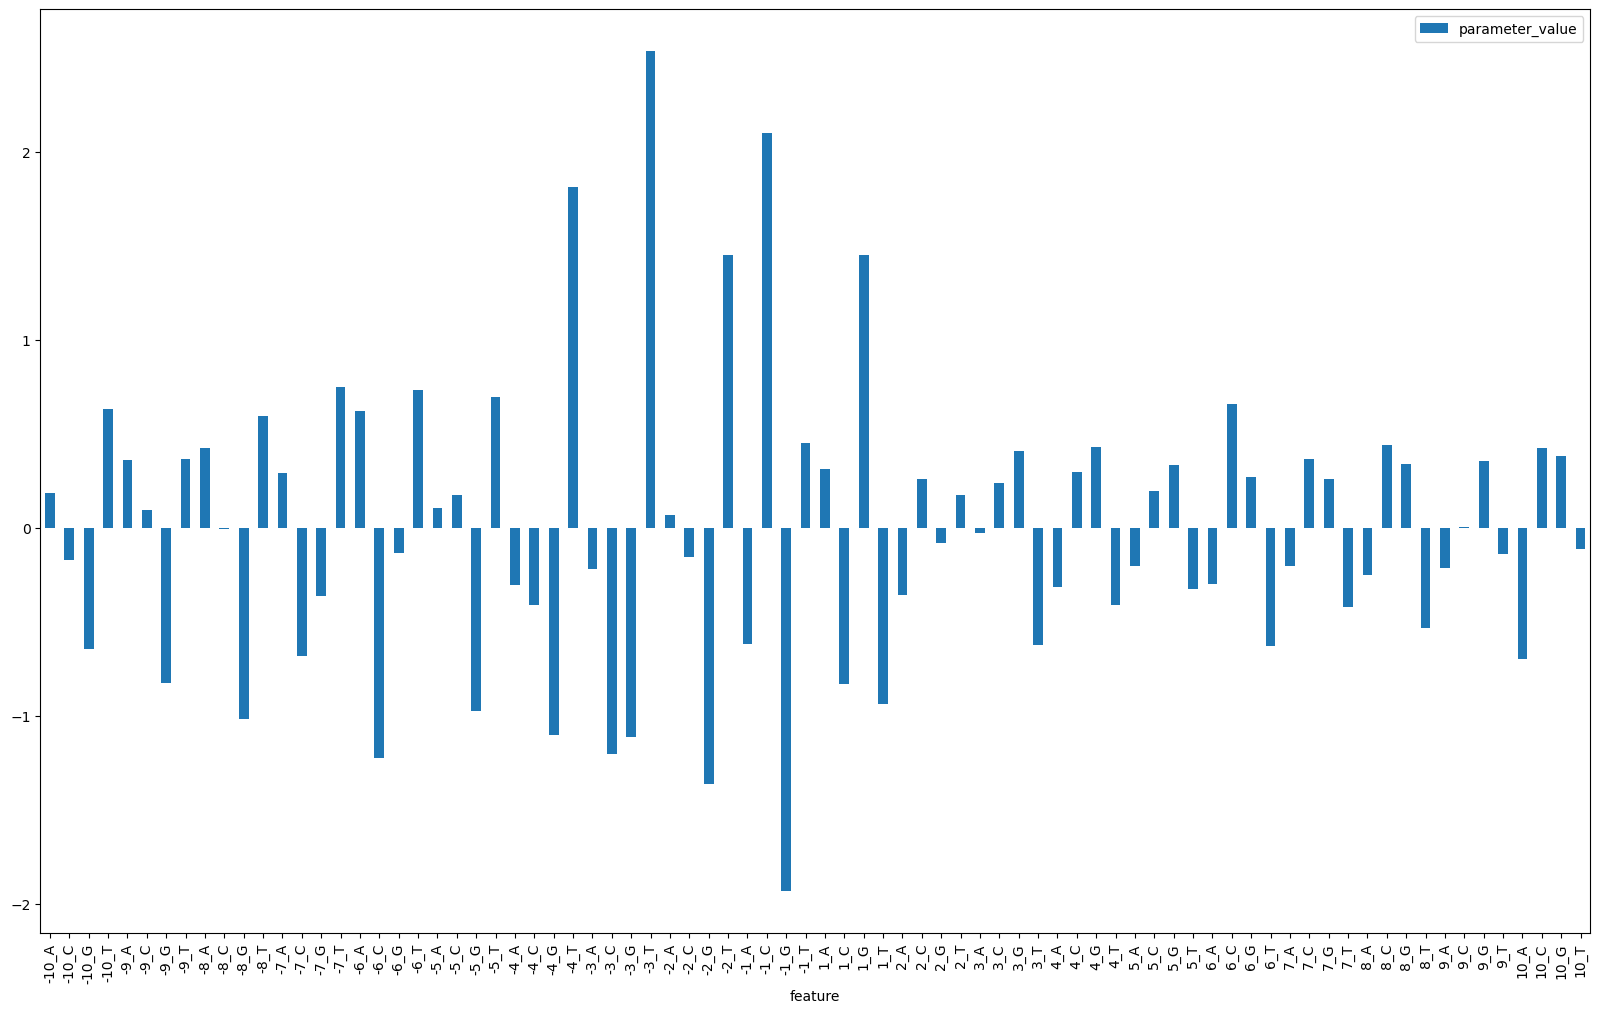

In [ ]:
model_parameters.plot.bar(x="feature",y="parameter_value",figsize=(20,12))

What are the most important one-hot encoded features for the fitted logistic regression model?